In [322]:
import numpy as np
from sklearn.datasets import make_classification
from collections import Counter
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay

# Data Generation 
- Use `make_classification` to generate synthetic data with imbalanced behavior between the two classes

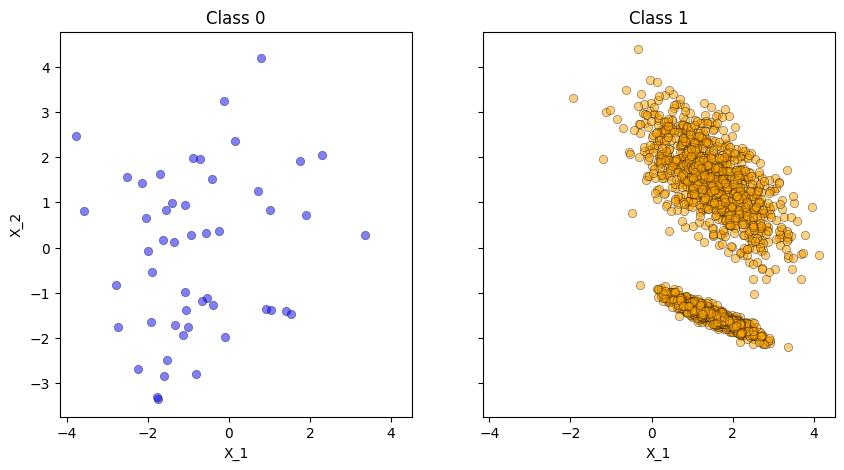

In [323]:
X, y = make_classification(n_samples=2000, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0, n_classes=2,
                           n_clusters_per_class=2,
                           weights=[0.02, 0.98],
                           class_sep=1.5, random_state=42, hypercube = True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex = True, sharey = True)
sns.scatterplot(x = X[y==0][:,0], y = X[y==0][:,1], alpha = 0.5, ax = ax1, edgecolor="k", c = 'blue')
ax1.set_xlabel('X_1')
ax1.set_ylabel('X_2')
ax1.set_title('Class 0')
sns.scatterplot(x = X[y==1][:,0], y = X[y==1][:,1], alpha = 0.5, ax = ax2, edgecolor="k", c = 'orange')
ax2.set_xlabel('X_1')
ax2.set_ylabel('X_2')
ax2.set_title('Class 1');

- We will test performance of different sampler via a specific classifier

In [324]:
model = LogisticRegression # LogisticRegression, RandomForestClassifier, HistGradientBoostingClassifier

# 1. Naive Random Over Sampling

In [325]:
def sort_nunique(x):
    return x[-1]

major_class, major_cnt = sorted(Counter(y).items(), key = sort_nunique, reverse=True)[0]
minor_class, minor_cnt = sorted(Counter(y).items(), key = sort_nunique, reverse=True)[-1]
X_major, y_major = X[y == major_class], y[y == major_class]
X_minor = X[y != major_class]

In [326]:
print('Number of major class sample:', major_cnt, '| Number of minor class sample:', minor_cnt)

Number of major class sample: 1950 | Number of minor class sample: 50


In [327]:
def naive_random_over_sampling(X, n):
    return np.array([random.choice(X.tolist()) for i in range(n)])
X_minor_resample = naive_random_over_sampling(X_minor, major_cnt)
y_minor_resample = np.array([minor_class for i in range(major_cnt)])
X_resample = np.concatenate((X_major,X_minor_resample), axis=0)
y_resample = np.concatenate((y_major,y_minor_resample), axis=0)

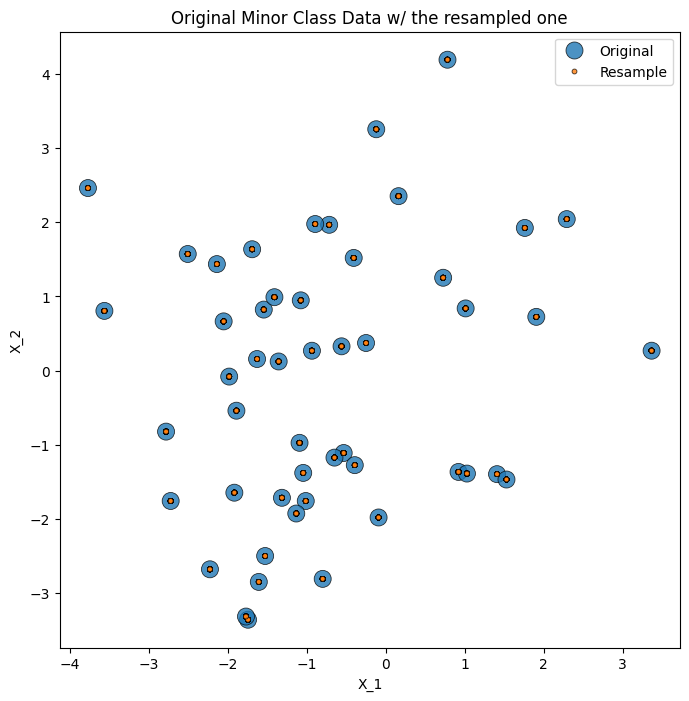

In [328]:
X_minor_plus_X_minor_resample = np.concatenate((X_minor,X_minor_resample), axis=0)
y_minor_plus_X_minor_resample = np.array(['Original' for i in range(minor_cnt)] + ['Resample' for i in range(major_cnt)])
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x = X_minor_plus_X_minor_resample[:,0], y = X_minor_plus_X_minor_resample[:,1], hue = y_minor_plus_X_minor_resample, alpha = 0.8, ax = ax, edgecolor="k", size = y_minor_plus_X_minor_resample, style = y_minor_plus_X_minor_resample, sizes = [150,50], markers = ['o', '.'])
ax.set_xlabel('X_1')
ax.set_ylabel('X_2')
ax.set_title('Original Minor Class Data w/ the resampled one');

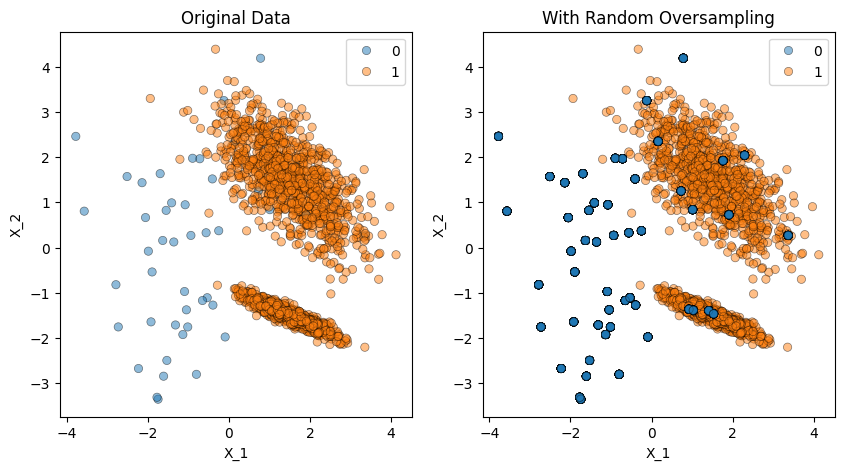

In [329]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(x = X[:,0], y = X[:,1], hue = y, alpha = 0.5, ax = ax1, edgecolor="k")
ax1.set_xlabel('X_1')
ax1.set_ylabel('X_2')
ax1.set_title('Original Data')
sns.scatterplot(x = X_resample[:,0], y = X_resample[:,1], hue = y_resample, alpha = 0.5, ax = ax2, edgecolor="k")
ax2.set_xlabel('X_1')
ax2.set_ylabel('X_2')
ax2.set_title('With Random Oversampling');

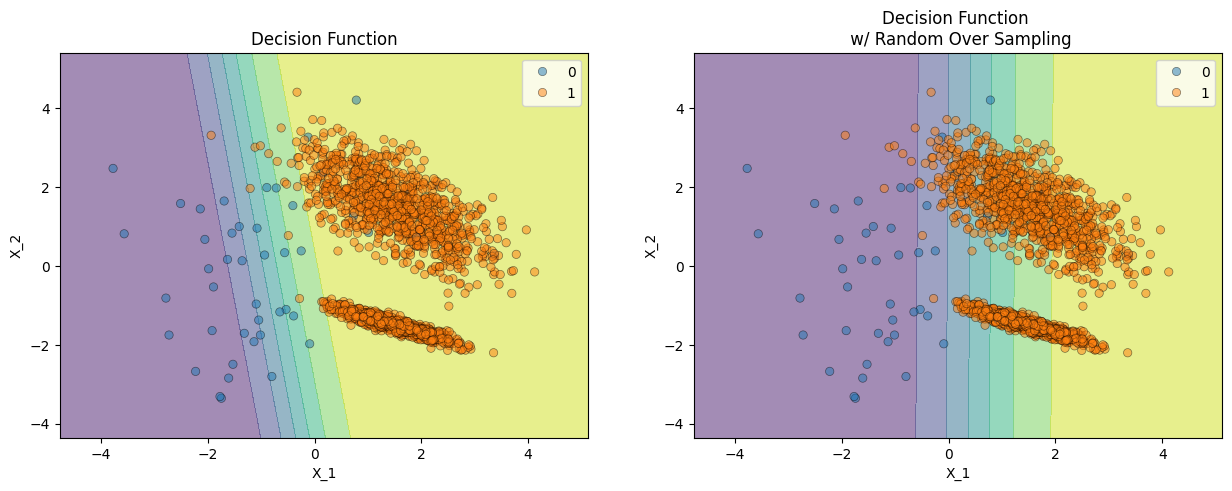

In [330]:
clf = model()
clf.fit(X, y)
clf_w_resample = model()
clf_w_resample.fit(X_resample, y_resample)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

DecisionBoundaryDisplay.from_estimator(
    clf, X, response_method="predict_proba",
    xlabel='X_1', ylabel='X_2',
    alpha=0.5, ax = ax1
)
DecisionBoundaryDisplay.from_estimator(
    clf_w_resample, X, response_method="predict_proba",
    xlabel='X_1', ylabel='X_2',
    alpha=0.5, ax = ax2
)
sns.scatterplot(x = X[:,0], y = X[:,1], hue = y, alpha = 0.5, ax = ax1, edgecolor="k")
ax1.set_title('Decision Function')
sns.scatterplot(x = X[:,0], y = X[:,1], hue = y, alpha = 0.5, ax = ax2, edgecolor="k")
ax2.set_title('Decision Function \n w/ Random Over Sampling');

              precision    recall  f1-score   support

           0       0.93      0.56      0.70        50
           1       0.99      1.00      0.99      1950

    accuracy                           0.99      2000
   macro avg       0.96      0.78      0.85      2000
weighted avg       0.99      0.99      0.99      2000

              precision    recall  f1-score   support

           0       0.18      0.78      0.29        50
           1       0.99      0.91      0.95      1950

    accuracy                           0.91      2000
   macro avg       0.59      0.84      0.62      2000
weighted avg       0.97      0.91      0.93      2000



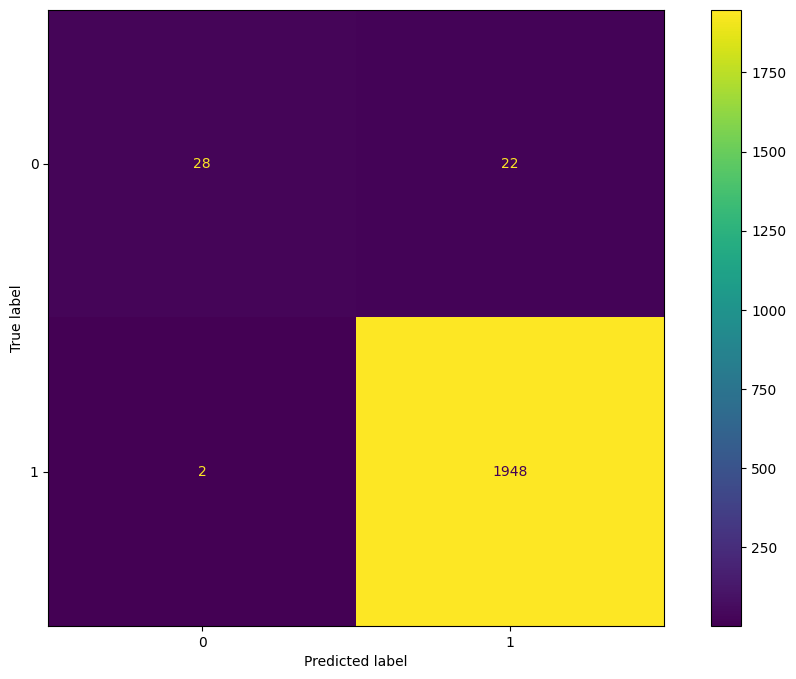

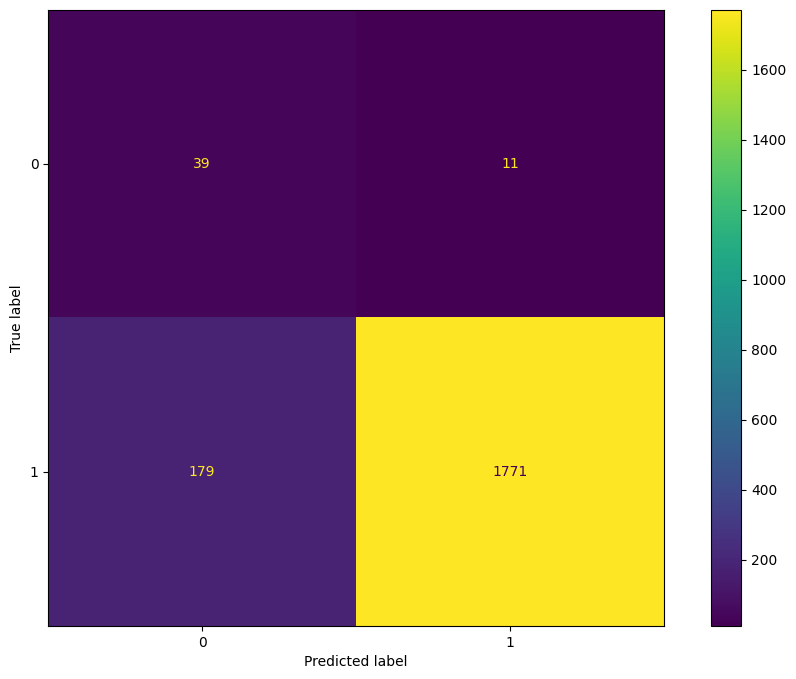

In [331]:
fig, ax = plt.subplots(figsize = (12, 8))
y_pred = clf.predict(X)
print(classification_report(y, y_pred))
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay.from_estimator(clf,X,y, ax = ax)
### 
fig, ax = plt.subplots(figsize = (12, 8))
y_pred = clf_w_resample.predict(X)
print(classification_report(y, y_pred))
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay.from_estimator(clf_w_resample,X,y, ax = ax)

# 2. Random Over Sampling Examples (ROSE)
Sample 𝑋 from the minority class only, then generate synthetic points around those using Gaussian noise based on the minority class's covariance structure.

In [332]:
def gaussian_random_over_sampling(X, n, h = 0.1):
    def generate_sample_with_noise(X, h):
        h = 0.1  # or tune this
        Sigma = np.cov(X_minor.T)
        H = h**2 * Sigma
        mean = np.zeros(X.shape[1])
        noise =  np.random.multivariate_normal(mean, H)
        X_old = np.array([random.choice(X.tolist())])
        X_new = X_old + noise
        return X_new
    for i in range(n):
        if i == 0:
            X_new = generate_sample_with_noise(X, h)
        else:
            X_new = np.vstack((X_new, generate_sample_with_noise(X, h)))
    return X_new

X_minor_resample = gaussian_random_over_sampling(X_minor, major_cnt, h = 0.05)
y_minor_resample = np.array([minor_class for i in range(major_cnt)])
X_resample = np.concatenate((X_major,X_minor_resample), axis=0)
y_resample = np.concatenate((y_major,y_minor_resample), axis=0)

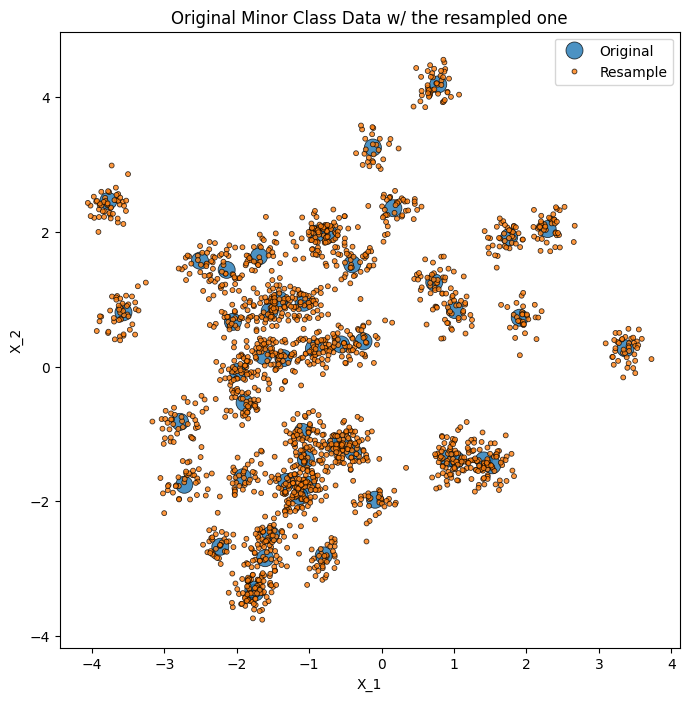

In [333]:
X_minor_plus_X_minor_resample = np.concatenate((X_minor,X_minor_resample), axis=0)
y_minor_plus_X_minor_resample = np.array(['Original' for i in range(minor_cnt)] + ['Resample' for i in range(major_cnt)])
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.scatterplot(x = X_minor_plus_X_minor_resample[:,0], y = X_minor_plus_X_minor_resample[:,1], hue = y_minor_plus_X_minor_resample, alpha = 0.8, ax = ax, edgecolor="k", size = y_minor_plus_X_minor_resample, style = y_minor_plus_X_minor_resample, sizes = [150,50], markers = ['o', '.'])
ax.set_xlabel('X_1')
ax.set_ylabel('X_2')
ax.set_title('Original Minor Class Data w/ the resampled one');

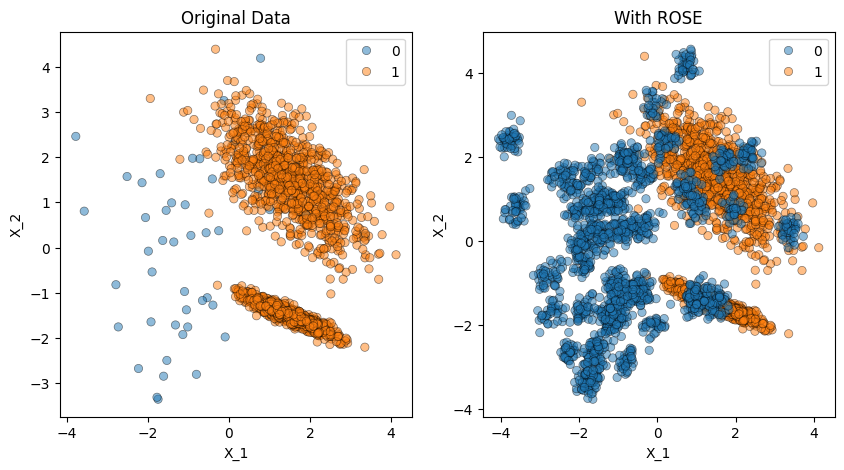

In [334]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(x = X[:,0], y = X[:,1], hue = y, alpha = 0.5, ax = ax1, edgecolor="k")
ax1.set_xlabel('X_1')
ax1.set_ylabel('X_2')
ax1.set_title('Original Data')
sns.scatterplot(x = X_resample[:,0], y = X_resample[:,1], hue = y_resample, alpha = 0.5, ax = ax2, edgecolor="k")
ax2.set_xlabel('X_1')
ax2.set_ylabel('X_2')
ax2.set_title('With ROSE');

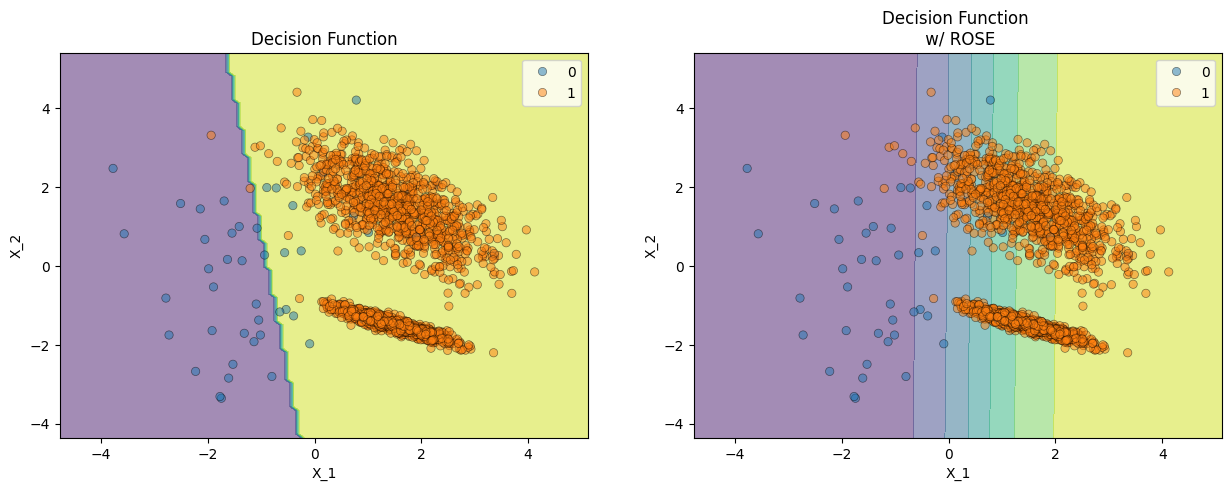

In [335]:
clf = model()
clf.fit(X, y)
clf_w_resample = model()
clf_w_resample.fit(X_resample, y_resample)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

DecisionBoundaryDisplay.from_estimator(
    clf, X, response_method="predict",
    xlabel='X_1', ylabel='X_2',
    alpha=0.5, ax = ax1
)
DecisionBoundaryDisplay.from_estimator(
    clf_w_resample, X, response_method="predict_proba",
    xlabel='X_1', ylabel='X_2',
    alpha=0.5, ax = ax2
)
sns.scatterplot(x = X[:,0], y = X[:,1], hue = y, alpha = 0.5, ax = ax1, edgecolor="k")
ax1.set_title('Decision Function')
sns.scatterplot(x = X[:,0], y = X[:,1], hue = y, alpha = 0.5, ax = ax2, edgecolor="k")
ax2.set_title('Decision Function \n w/ ROSE');

              precision    recall  f1-score   support

           0       0.93      0.56      0.70        50
           1       0.99      1.00      0.99      1950

    accuracy                           0.99      2000
   macro avg       0.96      0.78      0.85      2000
weighted avg       0.99      0.99      0.99      2000

              precision    recall  f1-score   support

           0       0.18      0.78      0.29        50
           1       0.99      0.91      0.95      1950

    accuracy                           0.90      2000
   macro avg       0.58      0.84      0.62      2000
weighted avg       0.97      0.90      0.93      2000



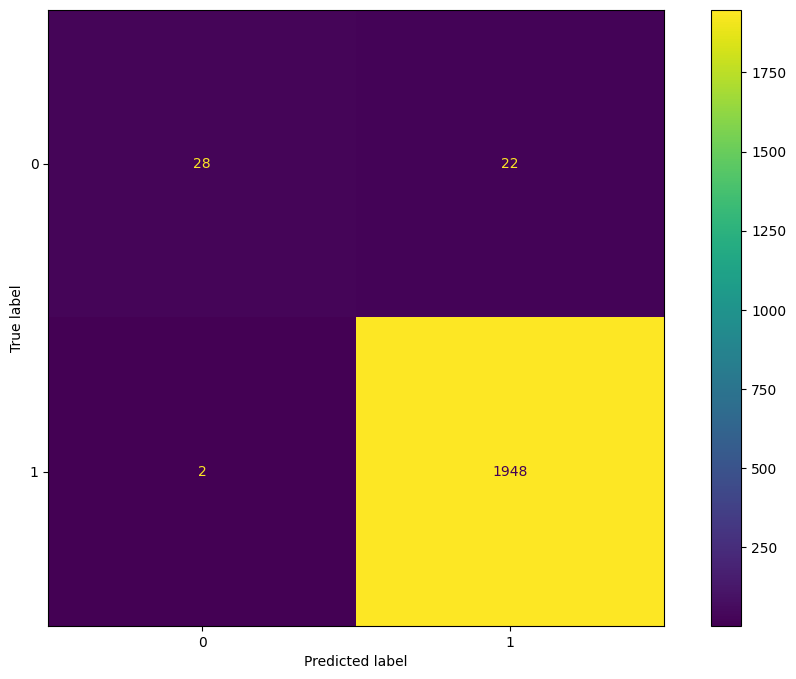

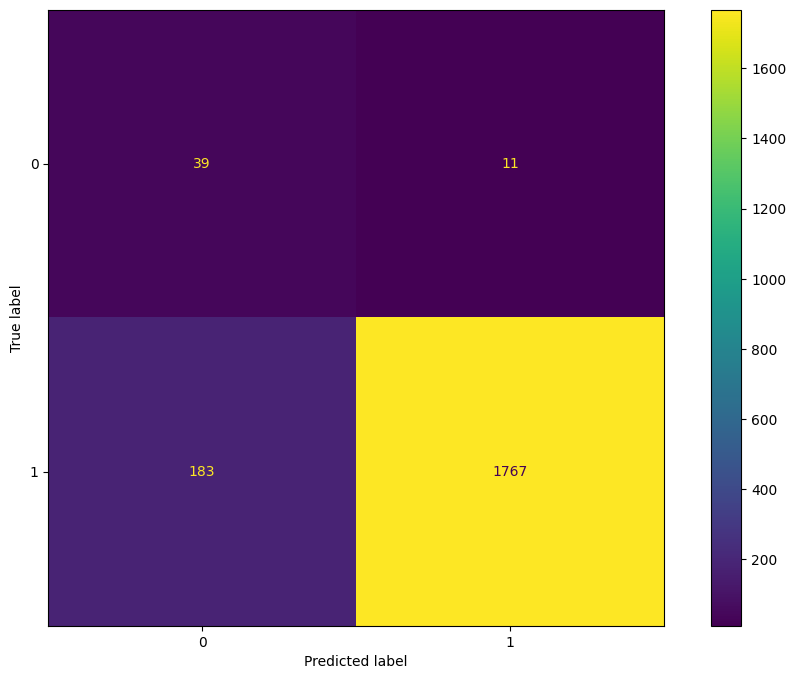

In [336]:
fig, ax = plt.subplots(figsize = (12, 8))
y_pred = clf.predict(X)
print(classification_report(y, y_pred))
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay.from_estimator(clf,X,y, ax = ax)
### 
fig, ax = plt.subplots(figsize = (12, 8))
y_pred = clf_w_resample.predict(X)
print(classification_report(y, y_pred))
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay.from_estimator(clf_w_resample,X,y, ax = ax)